In [41]:
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
import requests
import os
import io
import zipfile
import json
import requests
import urllib.request
import pandas as pd
import geopandas as gpd

# 対象地域・地理空間情報の取得

In [42]:
def save_shp(url:str, index:int|str)->gpd.GeoDataFrame():
    req = urllib.request.Request(url)
    with urllib.request.urlopen(req) as res:
        data = res.read()
    path = os.path.join(os.getcwd(), 'sources')
    os.makedirs(path, exist_ok=True)
    # データがzipファイルになっているので中身を抽出して変数に格納する
    with zipfile.ZipFile(io.BytesIO(data), 'r') as zip_data:
        zip_data.extractall(path)

In [43]:
# save_shp('https://www.esrij.com/cgi-bin/wp/wp-content/uploads/2012/10/japan_ver84.zip',0)
gdf = gpd.read_file(os.path.join(os.getcwd(), 'sources','japan_ver84/japan_ver84.shp'))
gdf_KEN = gdf.dissolve('KEN').query('KEN in ["茨城県","埼玉県", "千葉県", "東京都", "神奈川県"]')

# 相模原市はH22年に政令指定都市になったため統合
gdf_sagami = gdf.query('JCODE in ["14151","14152","14153"]').dissolve(by='SEIREI',aggfunc='sum')
gdf_sagami['JCODE'] = '14150'
gdf_sagami['KEN'] = '神奈川県'

gdf = gdf.query('JCODE not in ["14151","14152","14153"]')
gdf = gdf.query('KEN in ["茨城県", "埼玉県", "千葉県", "東京都", "神奈川県", "山梨県"]')
gdf_all = pd.concat([gdf, gdf_sagami]).sort_values('JCODE').reset_index()
gdf_all['P_DENS'] = gdf_all['P_NUM'] / (gdf_all['Shape_Area']*10000)

# gdf = gdf_all.query('SIKUCHOSON.str.contains("区") | P_NUM>150000', engine='python')
# 人口密度
gdf = gdf_all.query('P_DENS > 4000')
gdf = gdf.query('KEN not in ["茨城県","山梨県"]')
jcode = gdf.JCODE.to_list()
From = '11000'
To = '15000'

In [44]:
gdf.query('JCODE=="14153"')

,index,JCODE,KEN,SICHO,GUN,SEIREI,SIKUCHOSON,CITY_ENG,P_NUM,H_NUM,Shape_Leng,Shape_Area,geometry,P_DENS


111


<Axes: >

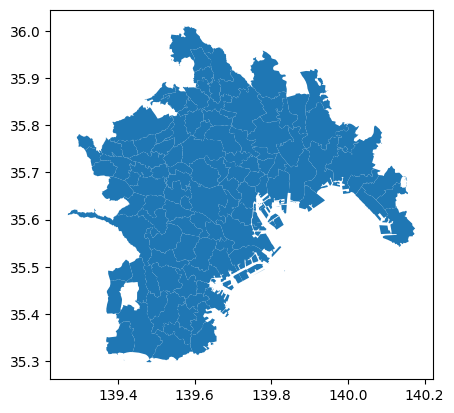

In [45]:
print(len(gdf))
gdf.plot()

# 地価情報の取得

In [46]:
# pd.read_excel('https://www.mlit.go.jp/totikensangyo/content/001733704.xls')
df = pd.read_excel('/Users/nagampere/File/horkew/analysis/master_thesis/sources/001733704.xls')
nayose = pd.read_csv('/Users/nagampere/File/horkew/analysis/master_thesis/sources/chika_nayose.csv')

In [47]:
df_all = pd.merge(nayose, 
                  df.loc[nayose['住宅'],['平成12年']].fillna(0).astype({'平成12年':int}).reset_index(),
                  left_on='住宅', right_on='index',how='left')
df_all = pd.merge(df_all,
                  df.loc[nayose['商業'],['平成12年']].fillna(0).astype({'平成12年':int}).reset_index(),
                  left_on='商業', right_on='index',how='left')
df_all = df_all.drop(columns=['index_x','index_y'])
df_all = df_all.rename(columns={'平成12年_x':'res_price','平成12年_y':'com_price'})
df_all = df_all.fillna(0)
df_all['jcode'] = df_all['JCODE'].astype(str)
df_all = df_all[df_all['jcode'].isin(jcode)].sort_values('JCODE').reset_index()

/var/folders/t1/7586sghj6mj42clxpt0kp3qr0000gn/T/ipykernel_38166/2128647120.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[nayose['住宅'],['平成12年']].fillna(0).astype({'平成12年':int}).reset_index(),
/var/folders/t1/7586sghj6mj42clxpt0kp3qr0000gn/T/ipykernel_38166/2128647120.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[nayose['商業'],['平成12年']].fillna(0).astype({'平成12年':int}).reset_index(),


In [48]:
df_all[(df_all['res_price']==0) | (df_all['com_price']==0)]

,index,JCODE,KEN,SICHO,GUN,SEIREI,SIKUCHOSON,CHIKA,住宅,商業,res_price,com_price,jcode
0,1,11102,埼玉県,0.0,0.0,さいたま市,北区,北区,9858,9862,0,0,11102
1,2,11103,埼玉県,0.0,0.0,さいたま市,大宮区,大宮区,9872,9876,0,0,11103
2,3,11104,埼玉県,0.0,0.0,さいたま市,見沼区,見沼区,9886,9890,0,0,11104
3,4,11105,埼玉県,0.0,0.0,さいたま市,中央区,中央区,9900,9904,0,0,11105
4,5,11106,埼玉県,0.0,0.0,さいたま市,桜区,桜区,9914,9918,0,0,11106
5,6,11107,埼玉県,0.0,0.0,さいたま市,浦和区,浦和区,9928,9932,0,0,11107
6,7,11108,埼玉県,0.0,0.0,さいたま市,南区,南区,9942,9946,0,0,11108
7,8,11109,埼玉県,0.0,0.0,さいたま市,緑区,緑区,9956,9960,0,0,11109
19,38,11234,埼玉県,0.0,0.0,0,八潮市,八潮市,10446,10450,175700,0,11234
22,47,11245,埼玉県,0.0,0.0,0,ふじみ野市,ふじみ野市,10600,10604,0,0,11245


In [13]:
df_all.at[0,'res_price'] = 111300 #BL10454 準工業地域の価格
df_all.at[0,'com_price'] = 111300 #BL10454 準工業地域の価格
df_all.at[1,'res_price'] = 111300 #BL10454 準工業地域の価格
df_all.at[1,'com_price'] = 111300 #BL10454 準工業地域の価格
df_all.at[2,'res_price'] = 111300 #BL10454 準工業地域の価格
df_all.at[2,'com_price'] = 111300 #BL10454 準工業地域の価格
df_all.at[3,'res_price'] = 111300 #BL10454 準工業地域の価格
df_all.at[3,'com_price'] = 111300 #BL10454 準工業地域の価格
df_all.at[4,'res_price'] = 111300 #BL10454 準工業地域の価格
df_all.at[4,'com_price'] = 111300 #BL10454 準工業地域の価格
df_all.at[5,'res_price'] = 111300 #BL10454 準工業地域の価格
df_all.at[5,'com_price'] = 111300 #BL10454 準工業地域の価格
df_all.at[6,'res_price'] = 111300 #BL10454 準工業地域の価格
df_all.at[6,'com_price'] = 111300 #BL10454 準工業地域の価格
df_all.at[7,'res_price'] = 111300 #BL10454 準工業地域の価格
df_all.at[7,'com_price'] = 111300 #BL10454 準工業地域の価格
df_all.at[8,'res_price'] = 111300 #BL10454 準工業地域の価格
df_all.at[8,'com_price'] = 111300 #BL10454 準工業地域の価格

df_all.at[19,'com_price'] = 111300 #BL10454 準工業地域の価格
df_all.at[22,'res_price'] = 176800 #BN10602 2008年の価格
df_all.at[22,'res_price'] = 306000 #BN10606 2008年の価格
df_all.at[79,'com_price'] = 111300 #BL10454 準工業地域の価格
df_all.at[79,'res_price'] = 111300 #BL10454 準工業地域の価格

In [14]:
# 2020年居住地価格を参考に、300,000円/坪で正規化
print('居住地価格平均値:', np.mean(df_all['res_price'].to_numpy()))
print('居住地価格中央値:', np.median(df_all['res_price'].to_numpy()))

居住地価格平均値: 263914.41441441444
居住地価格中央値: 210300.0


In [15]:
# 2020年居住地平均価格を参考に、300,000円/坪で正規化
df_all['q_i'] = df_all['res_price']/300000
df_all['Q_j'] = df_all['com_price']/300000

In [16]:
df_q_i = df_all[['jcode','q_i']].round(6)
df_Q_j = df_all[['jcode','Q_j']].round(6)

In [17]:
df_all

,index,JCODE,KEN,SICHO,GUN,SEIREI,SIKUCHOSON,CHIKA,住宅,商業,res_price,com_price,jcode,q_i,Q_j
0,1,11102,埼玉県,0.0,0.0,さいたま市,北区,北区,9858,9862,166500,282000,11102,0.555000,0.940000
1,2,11103,埼玉県,0.0,0.0,さいたま市,大宮区,大宮区,9872,9876,218200,680600,11103,0.727333,2.268667
2,3,11104,埼玉県,0.0,0.0,さいたま市,見沼区,見沼区,9886,9890,134600,228000,11104,0.448667,0.760000
3,4,11105,埼玉県,0.0,0.0,さいたま市,中央区,中央区,9900,9904,221000,268700,11105,0.736667,0.895667
4,5,11106,埼玉県,0.0,0.0,さいたま市,桜区,桜区,9914,9918,163600,181000,11106,0.545333,0.603333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,168,14205,神奈川県,0.0,0.0,0,藤沢市,藤沢市,13988,13992,194700,387200,14205,0.649000,1.290667
107,170,14207,神奈川県,0.0,0.0,0,茅ヶ崎市,茅ケ崎市,14016,14020,194900,308600,14207,0.649667,1.028667
108,175,14213,神奈川県,0.0,0.0,0,大和市,大和市,14086,14090,181000,277800,14213,0.603333,0.926000
109,177,14215,神奈川県,0.0,0.0,0,海老名市,海老名市,14114,14118,158200,345700,14215,0.527333,1.152333


# 通勤割合λ_ijの取得

In [75]:
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
     'lang':'J',
     'statsDataId':'0000033350',
     # 'metaGetFlg':'N',
     'explanationGetFlg':'N',
     'annotationGetFlg':'N',
     # 'cdCat02':'000',
     # 'cdCat03':'001',
     # 'cdArea':','.join(list),
     # # 'cdCat02':','.join(list)
     'lvArea':'4-',
     # 'cdArea': '11102',
     'cdAreaFrom': From,
     'cdAreaTo': To,
     # 'lvCat02':'4-',
     'cdCat01From':From,
     'cdCat01To':To,
     }


In [76]:
res = requests.get(URL,p)
text = res.json()
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])
text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']

項目名： １５歳以上自宅外就業者・通学者数 （常住地）都道府県・市区町村、（従業地）市区町村
ヒット件数： 18215


[{'@id': 'cat01',
  '@name': '従業通学地030223',
  'CLASS': [{'@code': '11201', '@name': '川越市', '@level': '4'},
   {'@code': '11202', '@name': '熊谷市', '@level': '4'},
   {'@code': '11203', '@name': '川口市', '@level': '4'},
   {'@code': '11204', '@name': '浦和市', '@level': '4'},
   {'@code': '11205', '@name': '大宮市', '@level': '4'},
   {'@code': '11206', '@name': '行田市', '@level': '4'},
   {'@code': '11207', '@name': '秩父市', '@level': '4'},
   {'@code': '11208', '@name': '所沢市', '@level': '4'},
   {'@code': '11209', '@name': '飯能市', '@level': '4'},
   {'@code': '11210', '@name': '加須市', '@level': '4'},
   {'@code': '11211', '@name': '本庄市', '@level': '4'},
   {'@code': '11212', '@name': '東松山市', '@level': '4'},
   {'@code': '11213', '@name': '岩槻市', '@level': '4'},
   {'@code': '11214', '@name': '春日部市', '@level': '4'},
   {'@code': '11215', '@name': '狭山市', '@level': '4'},
   {'@code': '11216', '@name': '羽生市', '@level': '4'},
   {'@code': '11217', '@name': '鴻巣市', '@level': '4'},
   {'@code': '11218', '@nam

In [79]:
df

,@cat01,@cat02,@area,@time,@unit,$
0,11201,001,11201,2000000000,人,77653
1,11201,001,11202,2000000000,人,427
2,11201,001,11203,2000000000,人,697
3,11201,001,11204,2000000000,人,1779
4,11201,001,11205,2000000000,人,3444
...,...,...,...,...,...,...
18210,14424,001,14401,2000000000,人,9
18211,14424,001,14421,2000000000,人,35
18212,14424,001,14422,2000000000,人,158
18213,14424,001,14423,2000000000,人,195


In [80]:
df = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])
# sagami = ["14151","14152","14153"]
# code = jcode + sagami
code = jcode
df_commute_ij = pd.DataFrame(0,columns=code,index=code)
for i in df.itertuples():
    if (i[1] not in code)|(i[3] not in code): continue
    if i[6] in ['-',None]: 
        df_commute_ij.at[i[3],i[1]]=0 # i[3]が居住地、i[1]が就業地
    else: 
        if int(i[6]) > 100: df_commute_ij.at[i[3],i[1]]=int(i[6])

In [81]:
df_commute_ij

,11102,11103,11104,11105,11106,11107,11108,11109,11203,11208,...,14134,14135,14136,14137,14204,14205,14207,14213,14215,14216
11102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14205,0,0,0,0,0,0,0,0,0,0,...,342,336,166,215,10722,93360,5504,3297,1687,531
14207,0,0,0,0,0,0,0,0,0,0,...,146,133,0,0,2828,13558,40288,669,935,236
14213,0,0,0,0,0,0,0,0,0,0,...,692,322,391,463,548,5920,451,40344,2054,3179
14215,0,0,0,0,0,0,0,0,0,0,...,180,210,108,240,183,1742,495,2331,19418,1788


In [57]:
# 相模原市の集計
# df_commute_ij.loc['14150',:]= df_commute_ij.loc[sagami,:].sum()
# df_commute_ij.loc[:,'14150'] = df_commute_ij.loc[:,sagami].sum(axis=1)
# df_commute_ij = df_commute_ij.drop(index=sagami, columns=sagami)

In [82]:
df_Pi_ij = (df_commute_ij/np.sum(df_commute_ij.to_numpy())).round(7)
df_Pi_ij

,11102,11103,11104,11105,11106,11107,11108,11109,11203,11208,...,14134,14135,14136,14137,14204,14205,14207,14213,14215,14216
11102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000041,0.000040,0.000020,0.000025,0.001273,0.011081,0.000653,0.000391,0.000200,0.000063
14207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000017,0.000016,0.000000,0.000000,0.000336,0.001609,0.004782,0.000079,0.000111,0.000028
14213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000082,0.000038,0.000046,0.000055,0.000065,0.000703,0.000053,0.004789,0.000244,0.000377
14215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000021,0.000025,0.000013,0.000029,0.000022,0.000207,0.000059,0.000277,0.002305,0.000212


# 世帯あたり子供の数n_ijの取得

In [19]:
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
     'lang':'J',
     'statsDataId':'0003445162',
     # 'metaGetFlg':'N',
     'explanationGetFlg':'N',
     'annotationGetFlg':'N',
     'cdCat01':'0',
     'cdCat02':'0',
     'cdCat03' :'01,02,03,04',
     'cdCat04' :'000',
     'cdCat05':'000',
     'cdAreaFrom': From,
     'cdAreaTo': To
     }

In [20]:
res = requests.get(URL,p)
text = res.json()
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])
text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']

項目名： 総人口・総世帯数・男女・年齢・配偶関係 男女，年齢（5歳階級），国籍総数か日本人別人口－全国，都道府県，市区町村（2000年（平成12年）市区町村含む）
ヒット件数： 1424


[{'@id': 'tab',
  '@name': '表章事項',
  'CLASS': {'@code': '2020_01', '@name': '人口', '@level': '', '@unit': '人'}},
 {'@id': 'cat01',
  '@name': '国籍総数か日本人',
  'CLASS': {'@code': '0', '@name': '国籍総数', '@level': '1'}},
 {'@id': 'cat02',
  '@name': '男女',
  'CLASS': {'@code': '0', '@name': '総数', '@level': '1'}},
 {'@id': 'cat03',
  '@name': '年齢',
  'CLASS': [{'@code': '01', '@name': '0～4歳', '@level': '1'},
   {'@code': '02', '@name': '5～9歳', '@level': '1'},
   {'@code': '03', '@name': '10～14歳', '@level': '1'},
   {'@code': '04', '@name': '15～19歳', '@level': '1'}]},
 {'@id': 'area',
  '@name': '全国，都道府県，市区町村（2000年市区町村含む）',
  'CLASS': [{'@code': '11000',
    '@name': '埼玉県',
    '@level': '2',
    '@parentCode': '00000'},
   {'@code': '11100', '@name': 'さいたま市', '@level': '4', '@parentCode': '11000'},
   {'@code': '11204',
    '@name': '（旧：浦和市）',
    '@level': '7',
    '@parentCode': '11000'},
   {'@code': '11205',
    '@name': '（旧：大宮市）',
    '@level': '7',
    '@parentCode': '11000'},
   {'@code':

In [21]:
pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])

,@tab,@cat01,@cat02,@cat03,@area,@time,@unit,$
0,2020_01,0,0,01,11000,2020000000,人,259281
1,2020_01,0,0,01,11100,2020000000,人,53391
2,2020_01,0,0,01,11204,2020000000,人,25417
3,2020_01,0,0,01,11205,2020000000,人,20124
4,2020_01,0,0,01,11213,2020000000,人,3845
...,...,...,...,...,...,...,...,...
1419,2020_01,0,0,04,14383,2020000000,人,224
1420,2020_01,0,0,04,14384,2020000000,人,849
1421,2020_01,0,0,04,14401,2020000000,人,1861
1422,2020_01,0,0,04,14402,2020000000,人,108


In [22]:
df = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])
df_children_i = pd.DataFrame(0,index=jcode, columns=[0])
for i in df.itertuples():
    try: 
        if i[8] == '-': pass
        else: 
            df_children_i.at[i[5],0] += int(i[8])
    except: pass

In [23]:
arr_children_ij = df_children_i.to_numpy() * df_commute_ij.to_numpy()/df_commute_ij.sum(axis=1).to_numpy().reshape(1,-1).T
df_children_ij = pd.DataFrame(arr_children_ij,index=jcode, columns=jcode)
df_children_ij = (df_children_ij/df_commute_ij).fillna(0)

In [24]:
df_children_ij

,11102,11103,11104,11105,11106,11107,11108,11109,11203,11208,...,14134,14135,14136,14137,14204,14205,14207,14213,14215,14216
11102,0.499354,0.499354,0.499354,0.499354,0.499354,0.499354,0.499354,0.499354,0.499354,0.499354,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11103,0.491206,0.491206,0.491206,0.491206,0.491206,0.491206,0.491206,0.491206,0.491206,0.491206,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11104,0.513775,0.513775,0.513775,0.513775,0.513775,0.513775,0.513775,0.513775,0.513775,0.513775,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11105,0.465114,0.465114,0.465114,0.465114,0.465114,0.465114,0.465114,0.465114,0.465114,0.465114,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11106,0.416956,0.416956,0.416956,0.416956,0.416956,0.416956,0.416956,0.416956,0.416956,0.416956,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.390984,0.390984,0.390984,0.390984,0.390984,0.390984,0.390984,0.390984,0.390984,0.390984
14207,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.403198,0.403198,0.000000,0.403198,0.403198,0.403198,0.403198,0.403198,0.403198,0.403198
14213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.381439,0.381439,0.381439,0.381439,0.381439,0.381439,0.381439,0.381439,0.381439,0.381439
14215,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.471389,0.471389,0.000000,0.471389,0.471389,0.471389,0.471389,0.471389,0.471389,0.471389


# 交通費用の算出

In [25]:
gdf_11 = gpd.read_file('https://nlftp.mlit.go.jp/ksj/gml/data/P34/P34-14/P34-14_11_GML.zip',encoding='CP932')
gdf_12 = gpd.read_file('https://nlftp.mlit.go.jp/ksj/gml/data/P34/P34-14/P34-14_12_GML.zip',encoding='CP932')
gdf_13 = gpd.read_file('https://nlftp.mlit.go.jp/ksj/gml/data/P34/P34-14/P34-14_13_GML.zip',encoding='CP932')
gdf_14 = gpd.read_file('https://nlftp.mlit.go.jp/ksj/gml/data/P34/P34-14/P34-14_14_GML.zip',encoding='CP932')
gdf_gov = pd.concat([gdf_11,gdf_12,gdf_13,gdf_14])
gdf_gov = gdf_gov[gdf_gov['P34_001'].isin(jcode)]
gdf_gov = gdf_gov[gdf_gov['P34_002']=='1'].sort_values('P34_001').reset_index(drop=True)

gdf_gov = gdf_gov.to_crs(epsg=4326)
def to_str(x):
    x = str(x)
    if len(x) == 1: x = '000'+x
    elif len(x) == 2: x = '00'+x
    elif len(x) == 3: x = '0'+x
    return x
gdf_PTzone = gpd.read_file('sources/H30_kzone_4326.geojson')
gdf_PTzone['kzone'] = gdf_PTzone['kzone'].apply(to_str)

gdf_gov = gdf_gov.sjoin(gdf_PTzone, how='left')

df_zc = pd.read_excel('/Users/nagampere/File/horkew/analysis/master_thesis/sources/zonecode_PT.xlsx', sheet_name='計基ゾーン対応', header=3, skiprows=[4])
df_zc['H30'] = df_zc['H30'].apply(to_str)
df_zc['H20'] = df_zc['H20'].apply(to_str)
df_zc['H10'] = df_zc['H10'].apply(to_str)

gdf_gov = gdf_gov.merge(df_zc[['H30','H20']], left_on='kzone', right_on='H30').drop(columns=['kzone','H30'])
gdf_gov['kzone'] = gdf_gov['H20']

In [26]:
df_time = pd.read_csv('sources/e-2_H20.csv', encoding='CP932', header=2)
df_time['発ゾーン'] = df_time['発ゾーン.1'].str.strip(':')
df_time['着ゾーン'] = df_time['着ゾーン.1'].str.strip(':')
ptcode = gdf_gov['kzone'].tolist()
df_time = df_time[(df_time['発ゾーン'].isin(ptcode))&(df_time['着ゾーン'].isin(ptcode))]

In [27]:
df_time = df_time.merge(gdf_gov[['P34_001','kzone']], left_on='発ゾーン', right_on='kzone', how='left').rename(columns={'P34_001':'ori_jcode'}).drop(columns='kzone')
df_time = df_time.merge(gdf_gov[['P34_001','kzone']], left_on='着ゾーン', right_on='kzone', how='left').rename(columns={'P34_001':'dst_jcode'}).drop(columns='kzone')

df_time['鉄道'] = df_time['鉄道・地下鉄'].where(df_time['鉄道・地下鉄'] !=0.0, df_time[['路線バス・都電','自動車']].apply(lambda x: np.round(np.mean(x),2), axis=1))

In [28]:
len(df_time['ori_jcode'].unique())

111

In [29]:
len(df_time['dst_jcode'].unique())

111

In [30]:
df_time_ij = (df_time.pivot_table(values='鉄道', index='ori_jcode', columns='dst_jcode', fill_value=df_time['鉄道'].max())/(60*24)).round(6)

In [31]:
df_time_ij

dst_jcode,11102,11103,11104,11105,11106,11107,11108,11109,11203,11208,...,14134,14135,14136,14137,14204,14205,14207,14213,14215,14216
ori_jcode,,,,,,,,,,,,,,,,,,,,,
11102,0.012319,0.020479,0.020910,0.029507,0.035938,0.031319,0.045382,0.034722,0.020139,0.034722,...,0.281250,0.281250,0.281250,0.070833,0.281250,0.281250,0.281250,0.281250,0.281250,0.281250
11103,0.019125,0.019229,0.020806,0.014681,0.021597,0.017681,0.026875,0.032174,0.031951,0.062500,...,0.281250,0.076389,0.065972,0.083333,0.281250,0.281250,0.281250,0.281250,0.281250,0.281250
11104,0.024174,0.022472,0.037542,0.030139,0.040931,0.031549,0.040792,0.055556,0.042354,0.281250,...,0.281250,0.281250,0.281250,0.281250,0.281250,0.281250,0.281250,0.000000,0.281250,0.281250
11105,0.030444,0.014368,0.031264,0.031312,0.024236,0.020479,0.026028,0.037611,0.028312,0.041667,...,0.281250,0.062500,0.062500,0.062500,0.281250,0.281250,0.281250,0.281250,0.281250,0.281250
11106,0.037833,0.026757,0.044396,0.022993,0.032750,0.027708,0.019917,0.035611,0.038167,0.041667,...,0.281250,0.281250,0.281250,0.069444,0.281250,0.281250,0.097222,0.281250,0.281250,0.281250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14205,0.281250,0.281250,0.281250,0.076389,0.281250,0.281250,0.281250,0.281250,0.281250,0.281250,...,0.281250,0.050111,0.051826,0.057458,0.031958,0.017819,0.024437,0.035840,0.042208,0.053403
14207,0.281250,0.281250,0.281250,0.281250,0.281250,0.281250,0.281250,0.281250,0.281250,0.281250,...,0.044444,0.281250,0.281250,0.062500,0.043479,0.026208,0.036472,0.047014,0.041979,0.048472
14213,0.281250,0.281250,0.000000,0.281250,0.281250,0.281250,0.281250,0.281250,0.281250,0.281250,...,0.041667,0.037688,0.031625,0.027854,0.090361,0.034562,0.046111,0.018368,0.033465,0.028611


In [32]:
gdf_gov = gdf_gov.to_crs(epsg=6677)
distance_matrix = gdf_gov.geometry.apply(lambda x: gdf_gov.distance(x)).values
distance_matrix = np.where(distance_matrix/1000 > 140/16.8, distance_matrix/1000*16.8, 140)
distance_matrix = distance_matrix / np.mean(distance_matrix) / 20
distance_matrix = np.round(distance_matrix, 5)
df_cost_ij = pd.DataFrame(distance_matrix,index=jcode, columns=jcode)

運賃の参考
初乗り: 140円
距離運賃: 16.2円/km
https://www.desktoptetsu.com/ryoki/ryoki1987.htm

In [33]:
df_cost_ij

,11102,11103,11104,11105,11106,11107,11108,11109,11203,11208,...,14134,14135,14136,14137,14204,14205,14207,14213,14215,14216
11102,0.01449,0.01449,0.01449,0.01449,0.01467,0.01449,0.01720,0.01535,0.02891,0.03484,...,0.06409,0.06086,0.06635,0.06574,0.11870,0.11612,0.12020,0.08938,0.10031,0.09176
11103,0.01449,0.01449,0.01449,0.01449,0.01449,0.01449,0.01449,0.01449,0.02425,0.03252,...,0.05934,0.05634,0.06173,0.06154,0.11406,0.11164,0.11599,0.08520,0.09635,0.08782
11104,0.01449,0.01449,0.01449,0.01449,0.01684,0.01449,0.01748,0.01449,0.02693,0.03919,...,0.06520,0.06261,0.06783,0.06810,0.12007,0.11790,0.12253,0.09176,0.10304,0.09452
11105,0.01449,0.01449,0.01449,0.01449,0.01449,0.01449,0.01449,0.01449,0.02129,0.02962,...,0.05498,0.05200,0.05737,0.05730,0.10969,0.10730,0.11174,0.08096,0.09221,0.08369
11106,0.01467,0.01449,0.01684,0.01449,0.01449,0.01449,0.01449,0.01449,0.02024,0.02469,...,0.04948,0.04621,0.05169,0.05133,0.10403,0.10149,0.10579,0.07499,0.08621,0.07768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14205,0.11612,0.11164,0.11790,0.10730,0.10149,0.10382,0.10065,0.10709,0.09764,0.08898,...,0.05355,0.05531,0.05023,0.05115,0.01449,0.01449,0.01449,0.02914,0.02611,0.03175
14207,0.12020,0.11599,0.12253,0.11174,0.10579,0.10874,0.10571,0.11262,0.10439,0.09045,...,0.06047,0.06048,0.05640,0.05446,0.02263,0.01449,0.01449,0.03082,0.02183,0.02987
14213,0.08938,0.08520,0.09176,0.08096,0.07499,0.07805,0.07508,0.08213,0.07468,0.06026,...,0.03204,0.03032,0.02733,0.02366,0.03537,0.02914,0.03082,0.01449,0.01449,0.01449
14215,0.10031,0.09635,0.10304,0.09221,0.08621,0.08965,0.08679,0.09406,0.08729,0.06925,...,0.04523,0.04297,0.04045,0.03536,0.03478,0.02611,0.02183,0.01449,0.01449,0.01449


# 土地賦存量

In [34]:
df_land = pd.read_excel('https://www.e-stat.go.jp/stat-search/file-download?statInfId=000031956084&fileKind=0', skiprows=[0,1,2,3,4,6,7,8,9], index_col='市区町村')

In [35]:
df_land['jcode'] = df_land['市区\n町村\nｺｰﾄﾞ'].astype(str)
df_land['K_i'] = df_land['可住地面積']*1000*1000
df_land = df_land[df_land['jcode'].isin(jcode)].reset_index()

In [36]:
df_land = df_land[['jcode','K_i']]
df_land

,jcode,K_i
0,11102,16850000.0
1,11103,12760000.0
2,11104,29700000.0
3,11105,8390000.0
4,11106,18310000.0
...,...,...
106,14205,63800000.0
107,14207,32720000.0
108,14213,25880000.0
109,14215,26080000.0


# 商業地比率の算出

データは建築着工統計調査から取得
https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00600120&tstat=000001016965&cycle=7&year=20120&month=0&result_back=1&tclass1val=0

In [37]:
# 左の列が床面積・右の列が棟数
df_area = pd.read_excel('https://www.e-stat.go.jp/stat-search/file-download?statInfId=000031871616&fileKind=0', skiprows=[0,1,2,3,5,6], index_col=0, usecols=[0,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58])
columns = {
    '用途　　　　(大分類)': 'jcode_name',
    'Unnamed: 4': '全建築物計' ,
    'Unnamed: 7': 'A居住専用住宅',
    'Unnamed: 10': 'B居住専用準住宅',
    'Unnamed: 13': 'C居住産業併用建築物',
    'Unnamed: 16': 'D農林水産業用建築物',
    'Unnamed: 19': 'E鉱業，採石業，砂利採取業，建設業用建築物',
    'Unnamed: 22': 'F製造業用建築物',
    'Unnamed: 25': 'G電気・ガス・熱供給・水道業用建築物',
    'Unnamed: 28': 'H情報通信業用建築物',
    'Unnamed: 31': 'I運輸業用建築物',
    'Unnamed: 34': 'J卸売業，小売業用建築物',
    'Unnamed: 37': 'K金融業，保険業用建築物',
    'Unnamed: 40': 'L不動産業用建築物',
    'Unnamed: 43': 'M宿泊業，飲食サービス業用建築物',
    'Unnamed: 46': 'N教育，学習支援業用建築物',
    'Unnamed: 49': 'O医療，福祉用建築物',
    'Unnamed: 52': 'Pその他のサービス業用建築物',
    'Unnamed: 55': 'Q公務用建築物',
    'Unnamed: 58': 'R他に分類されない建築物'
}
df_area = df_area.rename(columns=columns).fillna(0)
df_area = df_area.reset_index(drop=True)
df_area['jcode'] = df_area['jcode_name'].str.extract(r'^(.{5})')


In [38]:
df_area

,jcode_name,全建築物計,A居住専用住宅,B居住専用準住宅,C居住産業併用建築物,D農林水産業用建築物,E鉱業，採石業，砂利採取業，建設業用建築物,F製造業用建築物,G電気・ガス・熱供給・水道業用建築物,H情報通信業用建築物,...,J卸売業，小売業用建築物,K金融業，保険業用建築物,L不動産業用建築物,M宿泊業，飲食サービス業用建築物,N教育，学習支援業用建築物,O医療，福祉用建築物,Pその他のサービス業用建築物,Q公務用建築物,R他に分類されない建築物,jcode
0,01100札幌市,2341918.0,1443053.0,20023.0,81175.0,2518.0,4975.0,18979.0,7838.0,798.0,...,163809.0,1707.0,83859.0,10809.0,71725.0,228673.0,81779.0,22988.0,36241.0,01100
1,01101中央区,473200.0,255459.0,2125.0,20413.0,0.0,321.0,887.0,0.0,428.0,...,9887.0,899.0,72456.0,5156.0,11430.0,22187.0,48410.0,8869.0,13807.0,01101
2,01102北区,275066.0,216297.0,700.0,1456.0,50.0,504.0,338.0,714.0,0.0,...,5503.0,0.0,398.0,179.0,20736.0,17188.0,8125.0,354.0,2200.0,01102
3,01103東区,302477.0,178206.0,4559.0,3382.0,1209.0,1859.0,9191.0,865.0,151.0,...,8299.0,187.0,3361.0,214.0,1147.0,45652.0,2451.0,1530.0,4067.0,01103
4,01104白石区,293326.0,169370.0,993.0,19732.0,252.0,186.0,3950.0,1795.0,0.0,...,28397.0,0.0,621.0,212.0,206.0,39818.0,2720.0,1243.0,387.0,01104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213,47361久米島町,5008.0,2087.0,0.0,0.0,2336.0,0.0,69.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,516.0,0.0,47361
2214,47362八重瀬町,49774.0,30580.0,157.0,1752.0,841.0,282.0,0.0,1712.0,0.0,...,10775.0,0.0,199.0,272.0,261.0,1979.0,829.0,135.0,0.0,47362
2215,47380八重山郡,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47380
2216,47381竹富町,3814.0,515.0,0.0,0.0,123.0,0.0,0.0,56.0,0.0,...,0.0,0.0,0.0,110.0,2985.0,25.0,0.0,0.0,0.0,47381


In [39]:
df_area['res_area'] = df_area[[
    'A居住専用住宅',
    'B居住専用準住宅',
    'C居住産業併用建築物'
]].apply(lambda x: np.sum(x), axis=1)

df_area['com_area'] = df_area[[
    'D農林水産業用建築物',
    'E鉱業，採石業，砂利採取業，建設業用建築物',
    'F製造業用建築物',
    'G電気・ガス・熱供給・水道業用建築物',
    'H情報通信業用建築物',
    'I運輸業用建築物',
    'J卸売業，小売業用建築物',
    'K金融業，保険業用建築物',
    'L不動産業用建築物',
    'M宿泊業，飲食サービス業用建築物',
    'N教育，学習支援業用建築物',
    'O医療，福祉用建築物',
    'Pその他のサービス業用建築物',
    'Q公務用建築物',
    'R他に分類されない建築物'
]].apply(lambda x: np.sum(x), axis=1)
df_area['theta_i'] = df_area['com_area'] / (df_area['com_area']+df_area['res_area'])
df_area = df_area[df_area['jcode'].isin(jcode)]

In [40]:
df_theta = df_area[['jcode','theta_i']].reset_index(drop=True).round(6)

In [41]:
df_theta

,jcode,theta_i
0,11102,0.130420
1,11103,0.217978
2,11104,0.093022
3,11105,0.120900
4,11106,0.476352
...,...,...
106,14205,0.255620
107,14207,0.245671
108,14213,0.275546
109,14215,0.103253


# その他の指標

In [42]:
df_jcode = pd.DataFrame({'jcode':jcode})

In [43]:
df_p_i = pd.DataFrame({
    'jcode': jcode,
    'p_i':1
})

In [33]:
df_param = pd.DataFrame({
    'alpha': [0.8],
    'gamma': [0.375],
    'psi': [0.25],
    'mu_cost': [0.01], # 最低実質所得0.035のオーダーに合わせる
    'mu_time': [0.083], # 2/24日, つまり2時間に設定
    'mu_room': [0.01] # 
})

In [45]:
df_scaler = pd.DataFrame({
    'T': [1],
    'L': [0.66],
    'N': [np.sum(df_commute_ij.to_numpy())]
})

# データの保存

In [46]:
df_jcode.to_csv('data/2010/jcode.csv')
df_land.to_csv('data/2010/K_i.csv', index=False)
df_children_ij.to_csv('data/2010/n_ij.csv')
df_p_i.to_csv('data/2010/p_i.csv', index=False)
df_param.to_csv('data/2010/param.csv', index=False)
df_Pi_ij.to_csv('data/2010/Pi_ij.csv')
df_q_i.to_csv('data/2010/q_i.csv', index=False)
df_Q_j.to_csv('data/2010/Q_j.csv', index=False)
df_scaler.to_csv('data/2010/scaler.csv', index=False)
df_time_ij.to_csv('data/2010/t_ij.csv')
df_cost_ij.to_csv('data/2010/tau_ij.csv')
df_theta.to_csv('data/2010/theta_i.csv', index=False)

# 可視化

In [47]:
from libs_QSM.Plot_gdf import plot_gdf

df_Pi_ij_agg = pd.DataFrame({
    'jcode': df_Pi_ij.index,
    'Pi_i': df_Pi_ij.sum(axis=1, numeric_only=True).to_numpy()*np.sum(df_commute_ij.to_numpy()),
    'Pi_j': df_Pi_ij.sum(axis=0, numeric_only=True).to_numpy()*np.sum(df_commute_ij.to_numpy())
})

df_n_ij_agg = df_children_ij*df_Pi_ij*np.sum(df_commute_ij.to_numpy())
df_n_ij_agg = pd.DataFrame({
    'jcode': df_children_ij.index,
    'n_i': df_n_ij_agg.sum(axis=1, numeric_only=True).to_numpy(),
    'n_j': df_n_ij_agg.sum(axis=0, numeric_only=True).to_numpy(),
})

gdf_all['jcode'] = gdf_all['JCODE'].astype(str)
gdf_vis = gdf_all[gdf_all['JCODE'].notnull()]
gdf_vis = gdf_vis.merge(df_q_i, on='jcode', how='left')
gdf_vis = gdf_vis.merge(df_Q_j, on='jcode', how='left')
gdf_vis = gdf_vis.merge(df_p_i, on='jcode', how='left')
gdf_vis = gdf_vis.merge(df_Pi_ij_agg[['jcode','Pi_i','Pi_j']], on='jcode', how='left')
gdf_vis = gdf_vis.merge(df_n_ij_agg[['jcode','n_i','n_j']], on='jcode', how='left')

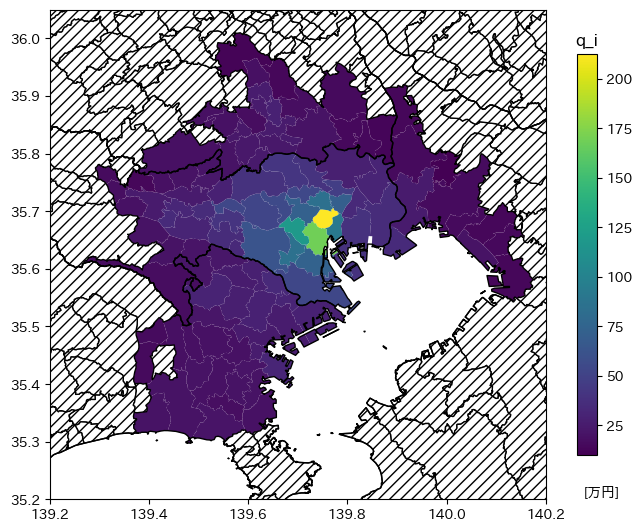

In [48]:
plot_gdf(gdf_vis, '2010', 'q_i', '[万円]', lambda x, pos: int(x*25))

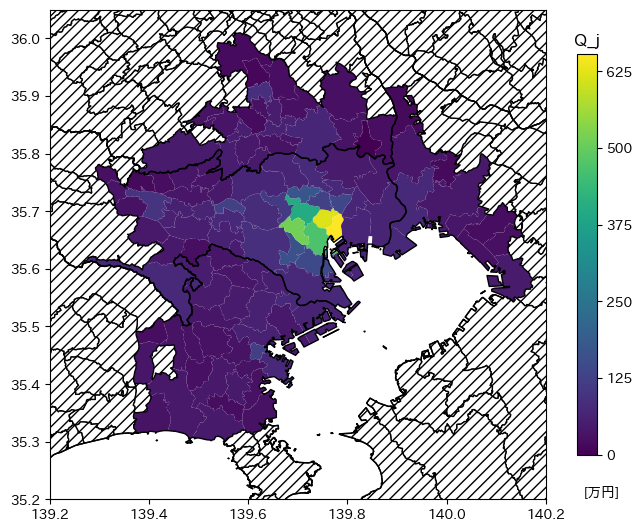

In [49]:
plot_gdf(gdf_vis, '2010', 'Q_j', '[万円]', lambda x, pos: int(x*25))

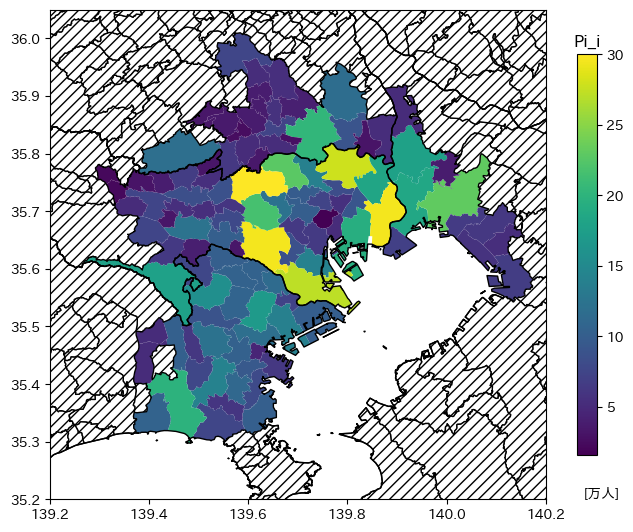

In [50]:
plot_gdf(gdf_vis, '2010', 'Pi_i', '[万人]', lambda x, pos: int(x/10000))

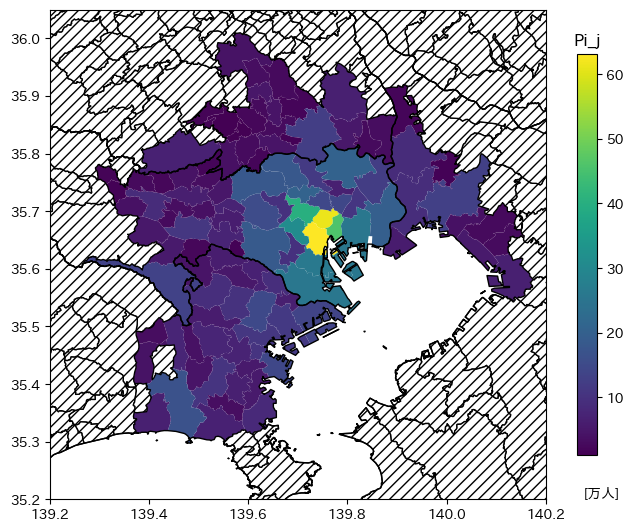

In [51]:
plot_gdf(gdf_vis, '2010', 'Pi_j', '[万人]', lambda x, pos: int(x/10000))

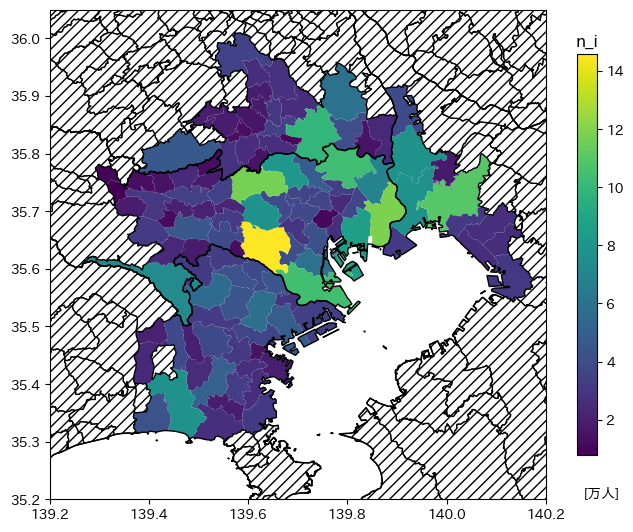

In [52]:
plot_gdf(gdf_vis, '2010', 'n_i', '[万人]', lambda x, pos: int(x/10000))

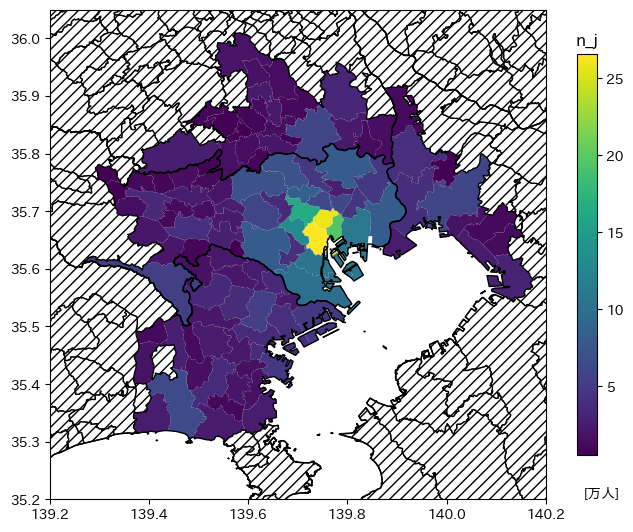

In [53]:
plot_gdf(gdf_vis, '2010', 'n_j', '[万人]', lambda x, pos: int(x/10000))